In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import mne

# NB: add more subjects in the data folder in neurolib package
from neurolib.utils.loadData import Dataset
from neurolib.models.aln import ALNModel

from coonectivity_dynamics import (plot_kuramoto_example,
                                   fast_kuramoto)
from neurolib.utils import functions as func
plt.style.use('seaborn')
# sns.set_style("whitegrid")
sns.set_style("white")
sns.set_context("talk")

In [2]:
ds = Dataset("gw")
model = ALNModel(Cmat=ds.Cmat, Dmat=ds.Dmat)
model.params['dt'] = 0.1
model.params['duration'] = 120 * 1000 #ms

# add custom parameter for downsampling results
# 10 ms sampling steps for saving data, should be multiple of dt
model.params['save_dt'] = 10.0
model.params["tauA"] = 600.0
model.params["sigma_ou"] = 0.0
model.params["b"] = 20.0

model.params["Ke_gl"] = 300.0
model.params["signalV"] = 80.0
model.params["mue_ext_mean"] = 0.2
model.params["mui_ext_mean"] = 0.1

# Sleep model from newest evolution October 2020
model.params["mue_ext_mean"] = 3.3202829454334535
model.params["mui_ext_mean"] = 3.682451894176651
model.params["b"] = 3.2021806735984186
model.params["tauA"] = 4765.3385276559875
model.params["sigma_ou"] = 0.36802952978628106
model.params["Ke_gl"] = 265.48075753153

model.run(bold=True)

In [17]:
path = "/Users/valery/Downloads/"

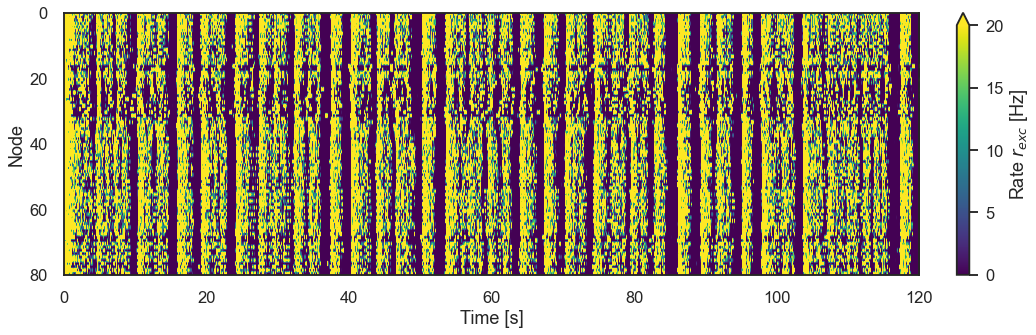

In [14]:
plt.figure(figsize=(15, 5))
plt.imshow(
            model.output, aspect="auto", extent=[0, model.t[-1] / 1000, model.params.N, 0],
            clim=(0, 20), cmap="viridis", 
        )
cbar = plt.colorbar(extend='max', fraction=0.046, pad=0.04)
cbar.set_label("Rate $r_{exc}$ [Hz]")
plt.ylabel("Node")
plt.xlabel("Time [s]")
plt.tight_layout()
plt.savefig(path + "sleep_ts.png", dpi=100)

# PLV

In [7]:
%%time
data = model.rates_exc

# sfreq = 1000 ??
con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(
    np.split(data, 12, axis=1), method='plv', 
    sfreq=10000, fmin=(0, 3, 14),
    fmax=(3, 14, 30), faverage=True)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3160 connections
    using t=0.000s..10.000s for estimation (100000 points)
    computing connectivity for the bands:
     band 1: 0.0Hz..3.0Hz (31 points)
     band 2: 3.0Hz..14.0Hz (111 points)
     band 3: 14.0Hz..30.0Hz (161 points)
    connectivity scores will be averaged for each band
/opt/anaconda3/envs/neurolib/lib/python3.7/site-packages/mne/connectivity/spectral.py:1010: RuntimeWarning: divide by zero encountered in double_scalars
  5. / np.min(fmin), five_cycle_freq))
<timed exec>:7: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 10.000 sec, need at least inf sec epochs or fmin=0.500. Spectrum estimate will be unreliable.
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLV
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivit

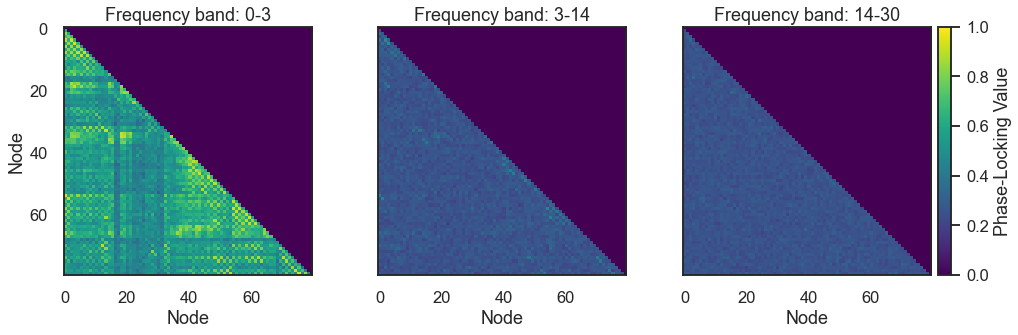

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)


for i, (_ax, freq_label) in enumerate(zip(ax, ("0-3", "3-14", "14-30"))):
    im = _ax.imshow(con[:,:,i], clim=(0, 1), cmap="viridis")
    _ax.set_title(f'Frequency band: {freq_label}')
    if i == 0:
        _ax.set_ylabel("Node")
    _ax.set_xlabel("Node")
    plt.tight_layout()

divider = make_axes_locatable(_ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Phase-Locking Value")
plt.tight_layout()
plt.savefig(path + "plv_freq_bands.png", dpi=100)


# Kuramoto

In [9]:
%%time
mkur = np.zeros((80, 80))
stdkur = np.zeros((80, 80))

for i, j in zip(np.tril_indices(80)[0], np.tril_indices(80)[1]):
    kur = fast_kuramoto(np.array([data[i, :200_000], data[j, :200_000]]))
    mkur[i, j] = kur.mean()
    stdkur[i, j] = kur.std()


CPU times: user 1min 10s, sys: 354 ms, total: 1min 10s
Wall time: 1min 10s


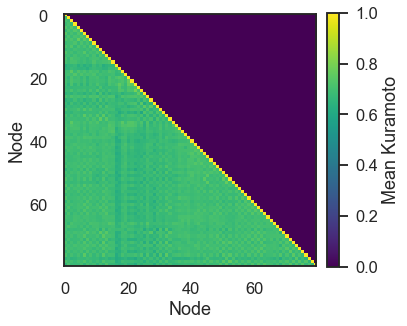

In [15]:
plt.figure(figsize=(6, 6))
plt.imshow(mkur, clim=(0, 1), cmap="viridis")
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Mean Kuramoto")
plt.ylabel("Node")
plt.xlabel("Node")
plt.tight_layout()
plt.savefig(path + "mean_kuramoto.png", dpi=100)

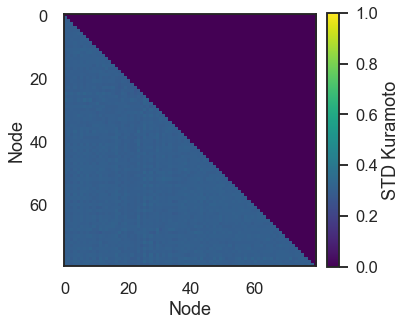

In [16]:
plt.figure(figsize=(6, 6))
plt.imshow(stdkur, clim=(0, 1), cmap="viridis")
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("STD Kuramoto")
plt.ylabel("Node")
plt.xlabel("Node")
plt.tight_layout()
plt.savefig(path + "std_kuramoto.png", dpi=100)

# DTW

In [22]:
from fastdtw import fastdtw


In [34]:
%%time
dtw = np.zeros((80, 80))

for i, j in zip(np.tril_indices(80)[0], np.tril_indices(80)[1]):
    distance, _ = fastdtw(data[i, ::100][:10_000], data[j, ::100][:10_000])
    dtw[i, j] = distance

CPU times: user 2min 1s, sys: 415 ms, total: 2min 2s
Wall time: 2min 2s


In [29]:
dtw_norm = dtw/dtw.max()

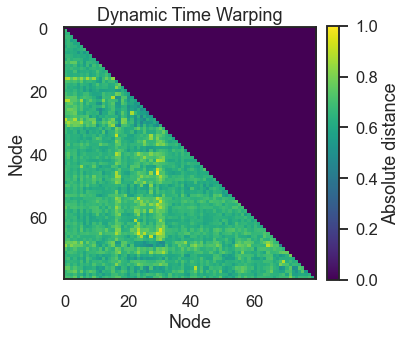

In [35]:
plt.figure(figsize=(6, 6))
plt.imshow(dtw_norm, clim=(0, 1), cmap="viridis")
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Absolute distance")
plt.ylabel("Node")
plt.xlabel("Node")
plt.title("Dynamic Time Warping")
plt.tight_layout()
plt.savefig(path + "dtw_norm.png", dpi=100)

# FC

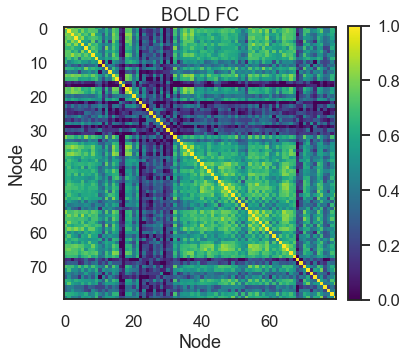

In [88]:
plt.figure(figsize=(6, 6))
plt.imshow(func.fc(model.BOLD.BOLD[:, 10:]), clim=(0, 1), cmap="viridis")
cbar = plt.colorbar(fraction=0.046, pad=0.04)
# cbar.set_label("Absolute distance")
plt.ylabel("Node")
plt.xlabel("Node")
plt.title("BOLD FC")
plt.tight_layout()
plt.savefig(path + "bold_fc.png", dpi=100)

# States

In [3]:
import brainplot as bp
from neurolib.utils import atlases
atlas = atlases.AutomatedAnatomicalParcellation2()

states = bp.detectSWs(model, filter_long=True)

durations = bp.get_state_lengths(states)
ups, downs = bp.get_updown_lengths(durations)

#involvement =  1 - np.sum(states, axis=0) / states.shape[0]
involvement = bp.get_involvement(states)

slope = 0.5518104681025502, intercept = 0.30862416640700063, r_value = 0.5473615125020392, p_value = 0.0, std_err = 0.009150119425931033


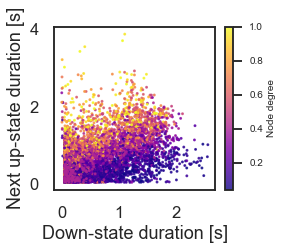

In [46]:
durations = bp.get_state_lengths(states)
ups, downs = bp.get_updown_lengths(durations)
bp.plot_down_up_durations(model, durations, ds)

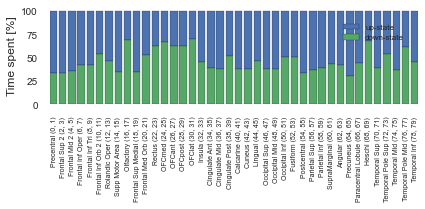

In [65]:
sns.set_context("paper")
area_downtimes, area_uptimes = bp.plot_state_brain_areas(model, states, atlas, ds, color_up="C0",  color_down="C1")
plt.tight_layout()
plt.savefig(path + "brain_ares_durations.pdf")

<Figure size 144x144 with 0 Axes>

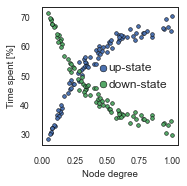

In [64]:
bp.plot_degree_duration_scatterplot(model, states, ds, color_up="C0",  color_down="C1")
plt.tight_layout()
plt.savefig(path + "degree_duration.pdf")

In [74]:
len(durations[2])

138

In [79]:
states.shape

(80, 1200000)

# SC-FC-states correlations

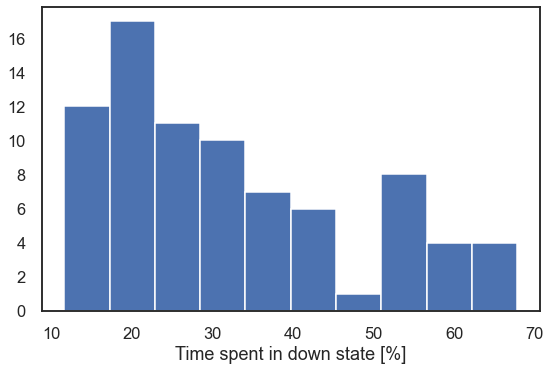

In [20]:
mean_states =  np.mean(states, axis=1) #  * 1000
len_states = np.sum(states, axis=1) * model.params.dt / 1000

normalized_down_lengths = model.params.duration / 1000 - len_states
normalized_down_lengths = normalized_down_lengths / (model.params.duration / 1000) * 100 # to percent
plt.hist(normalized_down_lengths)
plt.xlabel('Time spent in down state [%]')
plt.tight_layout()
plt.savefig(path + "time_spent_in_down.png")


In [79]:
normalized_down_lengths = 1 - normalized_down_lengths/100

In [92]:
from connectivity import (plot_graph_circos, make_graph, 
                          graph_measures, z_scores,
                          similarity_between_subjects, is_symmetric)

ds = Dataset("gw")
columns = ['mean_degree', 'degree', 'closeness', 'betweenness',
           'mean_shortest_path', 'neighbor_degree', 'neighbor_degree_new', 'clustering_coefficient', 'omega', 'sigma',
           'mean_clustering_coefficient', 'backbone', 'Cmat', 'Dmat']
df = pd.DataFrame(columns=columns)


G = make_graph(ds.Cmat)
G, gm = graph_measures(G) # , dmat
df.loc[0] = gm

results_sc =  pd.DataFrame(df.loc[0, ['degree', 'closeness', 'betweenness', 'neighbor_degree_new', 'clustering_coefficient']].to_dict())
results_sc.columns = ['degree_sc', 'closeness_sc', 'betweenness_sc', 'neighbor_sc', 'clustering_sc']

columns = ['mean_degree', 'degree', 'closeness', 'betweenness',
           'mean_shortest_path', 'neighbor_degree', 'neighbor_degree_new', 'clustering_coefficient', 'omega', 'sigma',
           'mean_clustering_coefficient', 'backbone', 'Cmat', 'Dmat']
df = pd.DataFrame(columns=columns)

fc = func.fc(model.BOLD.BOLD[:, 10:])
fc[fc<0] = 0
G = make_graph(fc)
G, gm = graph_measures(G) # , dmat
df.loc[0] = gm
results_fc =  pd.DataFrame(df.loc[0, ['degree', 'closeness', 'betweenness', 'neighbor_degree_new', 'clustering_coefficient']].to_dict())
results_fc.columns = ['degree_fc', 'closeness_fc', 'betweenness_fc', 'neighbor_fc', 'clustering_fc']


In [94]:
results = pd.concat([results_sc, results_fc], axis=1)

In [95]:
results.loc[:, 'time_up'] = normalized_down_lengths

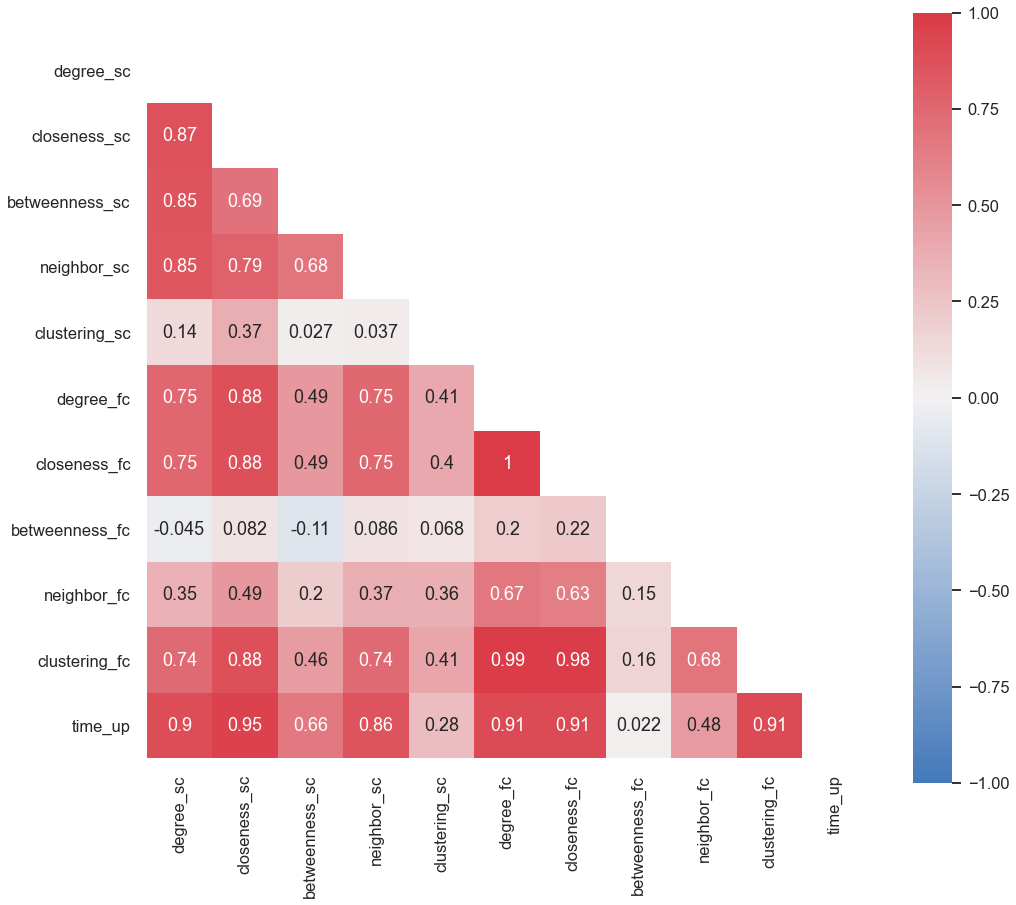

In [98]:
corr = results.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(250, 10, as_cmap=True)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 13))
    ax = sns.heatmap(corr, cmap=cmap, mask=mask, vmax=1., vmin=-1., square=True, annot=True)
    # plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig(path + "correlations.png")

In [102]:
len(ds.Cmats)

27